# Model Evaluation
The following notebook performs measures various metrics involving the models against the provided ground-truth data.
This notebook is meant to be used as a prototype workbench for developing core code for model performance evaluation and comparison.

In our evaluation pipeline, we closely follow the result analysis performed by Gabere et. al.

In [10]:
import math
import numpy as np
import seaborn as sns
import modin.pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.metrics import matthews_corrcoef, accuracy_score

In [3]:
# Application Hyperparameters
DATA_ROOT = '../data/out/data3.fasta.txt/'
# SERVERS = ['ADAM_HMM', 'ADAM_SVM', 'AMPA', 'CAMPR3-ANN', 'CAMPR3-DA', 'CAMPR3-RF', 'CAMPR3-SVM']
SERVERS = ['ADAM_HMM', 'ADAM_SVM', 'AMPA', 'CMPR3_ANN', 'CMPR3_DA', 'CMPR3_RF', 'CMPR3_SVM', 'DBAASP']
DATASET = ['A', 'D'] # A for AMP3 and D for DAMPD
REVERSE = ['', 'R', 'R1', 'R2', 'R3']

## Load Dataset

In [4]:
data = {}
for s in SERVERS:
    raw = pd.read_csv(DATA_ROOT + s + '.csv')
    data[s] = {}
    for d in DATASET:
        data[s][d] = {}
        for r in REVERSE:
            # Append True Values
            data[s][d][r] = pd.DataFrame(raw[raw.PepID.str.contains(d)][raw.PepID.str.contains('R') == False][raw.AMPLabel == 1])
            
            # Filter Out by
            if r == '':
                data[s][d][r] = data[s][d][r].append(raw[raw.PepID.str.contains(d)][raw.AMPLabel == 0][raw.PepID.str.contains('R') == False])
            elif r == 'R':
                data[s][d][r] = data[s][d][r].append(raw[raw.PepID.str.contains(d)][raw.PepID.str.contains('R') == True][raw.PepID.str.contains('R1') == False][raw.PepID.str.contains('R2') == False][raw.PepID.str.contains('R3') == False])
            else:
                data[s][d][r] = data[s][d][r].append(raw[raw.PepID.str.contains(d)][raw.PepID.str.contains(r)])
            
            print(s + ' ['+d+r+']' + ' : ' + str(data[s][d][r].shape[0]) + ' RECORDS')
        print('-'*30)

ADAM_HMM [A] : 10278 RECORDS
ADAM_HMM [AR] : 3426 RECORDS
ADAM_HMM [AR1] : 3426 RECORDS
ADAM_HMM [AR2] : 3426 RECORDS
ADAM_HMM [AR3] : 3426 RECORDS
------------------------------
ADAM_HMM [D] : 3281 RECORDS
ADAM_HMM [DR] : 1094 RECORDS
ADAM_HMM [DR1] : 1094 RECORDS
ADAM_HMM [DR2] : 1094 RECORDS
ADAM_HMM [DR3] : 1094 RECORDS
------------------------------
ADAM_SVM [A] : 10278 RECORDS
ADAM_SVM [AR] : 3426 RECORDS
ADAM_SVM [AR1] : 3426 RECORDS
ADAM_SVM [AR2] : 3426 RECORDS
ADAM_SVM [AR3] : 3426 RECORDS
------------------------------
ADAM_SVM [D] : 3281 RECORDS
ADAM_SVM [DR] : 1094 RECORDS
ADAM_SVM [DR1] : 1094 RECORDS
ADAM_SVM [DR2] : 1094 RECORDS
ADAM_SVM [DR3] : 1094 RECORDS
------------------------------
AMPA [A] : 10278 RECORDS
AMPA [AR] : 3426 RECORDS
AMPA [AR1] : 3426 RECORDS
AMPA [AR2] : 3426 RECORDS
AMPA [AR3] : 3426 RECORDS
------------------------------
AMPA [D] : 3281 RECORDS
AMPA [DR] : 1094 RECORDS
AMPA [DR1] : 1094 RECORDS
AMPA [DR2] : 1094 RECORDS
AMPA [DR3] : 1094 RECORDS


In [5]:
# Filter -999 Values
for s in SERVERS:
    for d in DATASET:
        for r in REVERSE:
            pre_filter = data[s][d][r].shape[0]
            data[s][d][r] = data[s][d][r].query('PredLabel != -999')
            print(s + ' ['+d+r+']' + ' (POST-FILTERED): ' + str(data[s][d][r].shape[0]) + ' RECORDS ' + '('+ str(pre_filter - data[s][d][r].shape[0]) +' FILTERED)')
        print('-'*75)

/usr/local/lib/python3.6/dist-packages/modin/pandas/dataframe.py:2901: UserWarning: User-defined function verification with DataFrame dtypes is still under development. Should be fully functional in a future release.
  UserWarning,


ADAM_HMM [A] (POST-FILTERED): 10276 RECORDS (2 FILTERED)
ADAM_HMM [AR] (POST-FILTERED): 3426 RECORDS (0 FILTERED)
ADAM_HMM [AR1] (POST-FILTERED): 3426 RECORDS (0 FILTERED)
ADAM_HMM [AR2] (POST-FILTERED): 3426 RECORDS (0 FILTERED)
ADAM_HMM [AR3] (POST-FILTERED): 3426 RECORDS (0 FILTERED)
---------------------------------------------------------------------------
ADAM_HMM [D] (POST-FILTERED): 3256 RECORDS (25 FILTERED)
ADAM_HMM [DR] (POST-FILTERED): 1078 RECORDS (16 FILTERED)
ADAM_HMM [DR1] (POST-FILTERED): 1078 RECORDS (16 FILTERED)
ADAM_HMM [DR2] (POST-FILTERED): 1078 RECORDS (16 FILTERED)
ADAM_HMM [DR3] (POST-FILTERED): 1078 RECORDS (16 FILTERED)
---------------------------------------------------------------------------
ADAM_SVM [A] (POST-FILTERED): 10274 RECORDS (4 FILTERED)
ADAM_SVM [AR] (POST-FILTERED): 3426 RECORDS (0 FILTERED)
ADAM_SVM [AR1] (POST-FILTERED): 3426 RECORDS (0 FILTERED)
ADAM_SVM [AR2] (POST-FILTERED): 3426 RECORDS (0 FILTERED)
ADAM_SVM [AR3] (POST-FILTERED): 3426 R

## Threshold Based Metrics

### Confusion Matrix

In [6]:
for s in SERVERS:
    for d in DATASET:
        for r in REVERSE:
            print('[' + s + ' ['+d+r+']' + ']')
            con_mat = confusion_matrix(data[s][d][r]['AMPLabel'], data[s][d][r]['PredLabel'], labels=[1, 0])
            print(str(con_mat) + '\n')
            print('True Positive:\t' + str(con_mat[0][0]))
            print('False Positive:\t' + str(con_mat[0][1]))
            print('False Negative:\t' + str(con_mat[1][0]))
            print('True Negative:\t' + str(con_mat[1][1]))
            print('-'*40)
    print('='* 40)

[ADAM_HMM [A]]
[[1558  155]
 [3254 5309]]

True Positive:	1558
False Positive:	155
False Negative:	3254
True Negative:	5309
----------------------------------------
[ADAM_HMM [AR]]
[[1558  155]
 [ 792  921]]

True Positive:	1558
False Positive:	155
False Negative:	792
True Negative:	921
----------------------------------------
[ADAM_HMM [AR1]]
[[1558  155]
 [ 489 1224]]

True Positive:	1558
False Positive:	155
False Negative:	489
True Negative:	1224
----------------------------------------
[ADAM_HMM [AR2]]
[[1558  155]
 [ 547 1166]]

True Positive:	1558
False Positive:	155
False Negative:	547
True Negative:	1166
----------------------------------------
[ADAM_HMM [AR3]]
[[1558  155]
 [ 765  948]]

True Positive:	1558
False Positive:	155
False Negative:	765
True Negative:	948
----------------------------------------
[ADAM_HMM [D]]
[[ 417  114]
 [ 809 1916]]

True Positive:	417
False Positive:	114
False Negative:	809
True Negative:	1916
----------------------------------------
[ADAM_HMM [

[[1624   89]
 [1418 7145]]

True Positive:	1624
False Positive:	89
False Negative:	1418
True Negative:	7145
----------------------------------------
[CMPR3_RF [AR]]
[[1624   89]
 [1571  142]]

True Positive:	1624
False Positive:	89
False Negative:	1571
True Negative:	142
----------------------------------------
[CMPR3_RF [AR1]]
[[1624   89]
 [1563  150]]

True Positive:	1624
False Positive:	89
False Negative:	1563
True Negative:	150
----------------------------------------
[CMPR3_RF [AR2]]
[[1624   89]
 [1552  161]]

True Positive:	1624
False Positive:	89
False Negative:	1552
True Negative:	161
----------------------------------------
[CMPR3_RF [AR3]]
[[1624   89]
 [1538  175]]

True Positive:	1624
False Positive:	89
False Negative:	1538
True Negative:	175
----------------------------------------
[CMPR3_RF [D]]
[[ 505   31]
 [ 728 1969]]

True Positive:	505
False Positive:	31
False Negative:	728
True Negative:	1969
----------------------------------------
[CMPR3_RF [DR]]
[[505  31]
 [4

In [7]:
print('Classification Report')

for s in SERVERS:
    for d in DATASET:
        for r in REVERSE:
            print('['+s + ' ['+d+r+']'+']')
            print(classification_report(data[s][d][r]['AMPLabel'], data[s][d][r]['PredLabel'], [0, 1]))
            print('='*40)

Classification Report
[ADAM_HMM [A]]
             precision    recall  f1-score   support

          0       0.97      0.62      0.76      8563
          1       0.32      0.91      0.48      1713

avg / total       0.86      0.67      0.71     10276

[ADAM_HMM [AR]]
             precision    recall  f1-score   support

          0       0.86      0.54      0.66      1713
          1       0.66      0.91      0.77      1713

avg / total       0.76      0.72      0.71      3426

[ADAM_HMM [AR1]]
             precision    recall  f1-score   support

          0       0.89      0.71      0.79      1713
          1       0.76      0.91      0.83      1713

avg / total       0.82      0.81      0.81      3426

[ADAM_HMM [AR2]]
             precision    recall  f1-score   support

          0       0.88      0.68      0.77      1713
          1       0.74      0.91      0.82      1713

avg / total       0.81      0.80      0.79      3426

[ADAM_HMM [AR3]]
             precision    recall  f1

             precision    recall  f1-score   support

          0       0.49      0.19      0.28       536
          1       0.50      0.80      0.61       536

avg / total       0.50      0.50      0.45      1072

[CMPR3_ANN [DR1]]
             precision    recall  f1-score   support

          0       0.50      0.20      0.29       536
          1       0.50      0.80      0.62       536

avg / total       0.50      0.50      0.45      1072

[CMPR3_ANN [DR2]]
             precision    recall  f1-score   support

          0       0.49      0.19      0.27       536
          1       0.50      0.80      0.61       536

avg / total       0.49      0.50      0.44      1072

[CMPR3_ANN [DR3]]
             precision    recall  f1-score   support

          0       0.49      0.19      0.27       536
          1       0.50      0.80      0.61       536

avg / total       0.49      0.50      0.44      1072

[CMPR3_DA [A]]
             precision    recall  f1-score   support

          0      

             precision    recall  f1-score   support

          0       0.55      0.10      0.16       536
          1       0.50      0.92      0.65       536

avg / total       0.53      0.51      0.41      1072

[CMPR3_SVM [DR3]]
             precision    recall  f1-score   support

          0       0.56      0.10      0.17       536
          1       0.51      0.92      0.65       536

avg / total       0.53      0.51      0.41      1072

[DBAASP [A]]
             precision    recall  f1-score   support

          0       0.93      0.91      0.92      8409
          1       0.58      0.64      0.61      1682

avg / total       0.87      0.86      0.87     10091

[DBAASP [AR]]
             precision    recall  f1-score   support

          0       0.57      0.48      0.52      1682
          1       0.55      0.64      0.59      1682

avg / total       0.56      0.56      0.56      3364

[DBAASP [AR1]]
             precision    recall  f1-score   support

          0       0.70    

### ROC/AUC Curve

#### Total ROC/AUC Score

In [8]:
for s in SERVERS:
    for d in DATASET:
        for r in REVERSE:
            print(s + ' ['+d+r+']' + ' SCORE:\t'+str(roc_auc_score(data[s][d][r]['AMPLabel'], data[s][d][r]['PredScore'])))
        print('-'*30)

ADAM_HMM [A] SCORE:	0.7647542315228382
ADAM_HMM [AR] SCORE:	0.7235843549328663
ADAM_HMM [AR1] SCORE:	0.812025685931115
ADAM_HMM [AR2] SCORE:	0.7950963222416814
ADAM_HMM [AR3] SCORE:	0.7314652656158785
------------------------------
ADAM_HMM [D] SCORE:	0.7442150002591613
ADAM_HMM [DR] SCORE:	0.6248308699738687
ADAM_HMM [DR1] SCORE:	0.7655986944711265
ADAM_HMM [DR2] SCORE:	0.7454890052572326
ADAM_HMM [DR3] SCORE:	0.6961288590049474
------------------------------
ADAM_SVM [A] SCORE:	0.7647682477584545
ADAM_SVM [AR] SCORE:	0.5
ADAM_SVM [AR1] SCORE:	0.5
ADAM_SVM [AR2] SCORE:	0.49883245767659073
ADAM_SVM [AR3] SCORE:	0.49854057209573843
------------------------------
ADAM_SVM [D] SCORE:	0.7399673300248413
ADAM_SVM [DR] SCORE:	0.4609471439793514
ADAM_SVM [DR1] SCORE:	0.4609471439793514
ADAM_SVM [DR2] SCORE:	0.45908147233756036
ADAM_SVM [DR3] SCORE:	0.4618799798002469
------------------------------
AMPA [A] SCORE:	0.6344937689405781
AMPA [AR] SCORE:	0.5089621113707681
AMPA [AR1] SCORE:	0.51325

### Classification Report
The following metrics are utilized in the submission report based on the provided format.

In [11]:
'''
Convert predicted probabilities into predicted binary labels

Paramters:
probs: np array [num_samples]. Predicted probability scores of the target class (e.g., class 1)
cutoff: cutoff score.
'''
def getLabels (probs, cutoff=0.5):
    size  = np.shape(probs)[0]
    labels = np.zeros(size)
    for i in range (size):
        if (probs[i] < cutoff):
            labels[i] = 0
        else:
            labels[i] = 1
    return labels

'''
Determines different performance metrics for binary predictions over a dataset.

Parameters
Y_true: np array[num_samples]. True labels.
Y_pred: np array[num_samples]. Predicted probability scores of the target class.
cutoff: cutoff score.
'''
def evaluate(Y_true, Y_pred, cutoff=0.5):
    Y_score = getLabels(Y_pred, cutoff)
    mcc = matthews_corrcoef(Y_true, Y_score)
    acc = accuracy_score(Y_true, Y_score)
    auc = roc_auc_score(Y_true, Y_pred)
    cm = confusion_matrix(Y_true, Y_score, labels=[1,0])
    #print(cm)
    tp = cm[0,0]
    fp = cm[1,0]
    tn = cm[1,1]
    fn = cm[0,1]
    ap = tp + fn
    an = tn + fp
    total = ap + an
    # compute Sn and Sp
    sn = tp/ap
    sp = tn/an
    # return TP, FN, FP, TN, total, acc, Sn, Sp, MCC, AUC
    return  np.array([acc, sn, sp, mcc, auc])

In [43]:
for s in SERVERS:
    for d in DATASET:
        for r in REVERSE:
            out = evaluate(data[s][d][r]['AMPLabel'].values, data[s][d][r]['PredScore'].values)
            print(s + ' ['+d+r+']')
            print('Accuracy:\t', out[0])
            print('Sensitivity:\t', out[1])
            print('Specificity:\t', out[2])
            print('MCC:\t\t', out[3])
            print('AUC:\t\t', out[4])
            print('-' * 30)

ADAM_HMM [A]
Accuracy:	 0.6682561307901907
Sensitivity:	 0.9095154699357851
Specificity:	 0.6199929931098914
MCC:		 0.3954999241817393
AUC:		 0.7647542315228382
------------------------------
ADAM_HMM [AR]
Accuracy:	 0.7235843549328663
Sensitivity:	 0.9095154699357851
Specificity:	 0.5376532399299475
MCC:		 0.48171337273474796
AUC:		 0.7235843549328663
------------------------------
ADAM_HMM [AR1]
Accuracy:	 0.812025685931115
Sensitivity:	 0.9095154699357851
Specificity:	 0.7145359019264448
MCC:		 0.6362629735339091
AUC:		 0.812025685931115
------------------------------
ADAM_HMM [AR2]
Accuracy:	 0.7950963222416813
Sensitivity:	 0.9095154699357851
Specificity:	 0.6806771745475774
MCC:		 0.6062806348480937
AUC:		 0.7950963222416814
------------------------------
ADAM_HMM [AR3]
Accuracy:	 0.7314652656158785
Sensitivity:	 0.9095154699357851
Specificity:	 0.553415061295972
MCC:		 0.4954055027107168
AUC:		 0.7314652656158785
------------------------------
ADAM_HMM [D]
Accuracy:	 0.716523341

CMPR3_DA [DR1]
Accuracy:	 0.4925373134328358
Sensitivity:	 0.8582089552238806
Specificity:	 0.12686567164179105
MCC:		 -0.021884405476620426
AUC:		 0.5234862302294498
------------------------------
CMPR3_DA [DR2]
Accuracy:	 0.4916044776119403
Sensitivity:	 0.8582089552238806
Specificity:	 0.125
MCC:		 -0.024692589337165807
AUC:		 0.515108111494765
------------------------------
CMPR3_DA [DR3]
Accuracy:	 0.4878731343283582
Sensitivity:	 0.8582089552238806
Specificity:	 0.11753731343283583
MCC:		 -0.03609899658252663
AUC:		 0.5066342726665181
------------------------------
CMPR3_RF [A]
Accuracy:	 0.85325029194239
Sensitivity:	 0.9480443666082895
Specificity:	 0.8342870489314492
MCC:		 0.6386636740366725
AUC:		 0.9527582352263049
------------------------------
CMPR3_RF [AR]
Accuracy:	 0.5154699357851722
Sensitivity:	 0.9480443666082895
Specificity:	 0.08289550496205488
MCC:		 0.061692795277079
AUC:		 0.64146090692752
------------------------------
CMPR3_RF [AR1]
Accuracy:	 0.5178050204319

In [9]:
# Plot ROC/AUC
def plot_roc(name, d, r):
    plt.title(name + r + ' ROC')
    for s in SERVERS:
        fpr, tpr, threshold = roc_curve(data[s][d][r]['AMPLabel'], data[s][d][r]['PredScore'])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label = s + ': %0.2f' % roc_auc)

    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

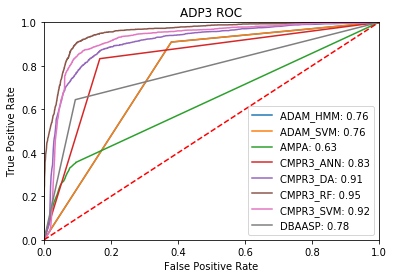

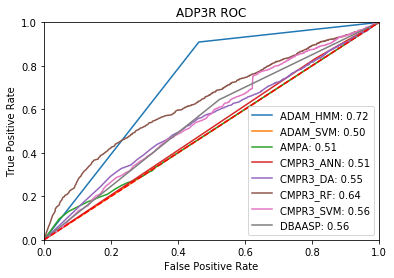

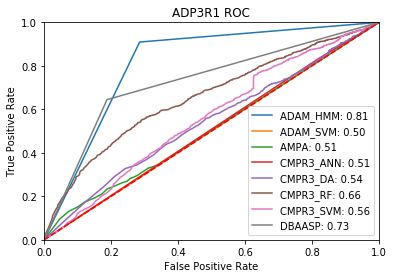

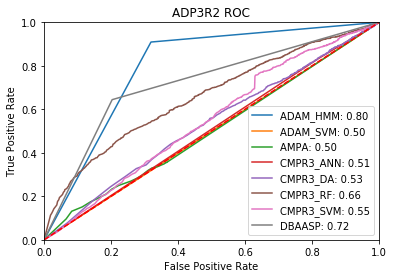

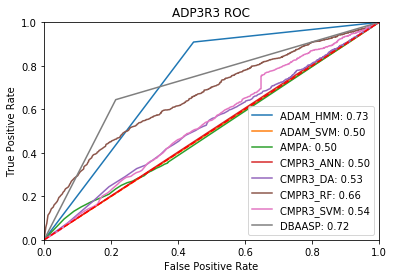

In [9]:
for r in REVERSE:
    plot_roc('ADP3', 'A', r)

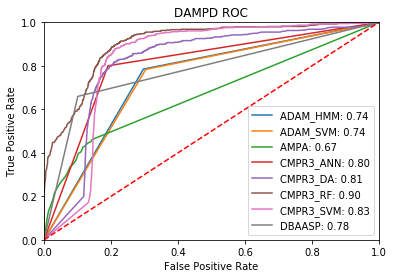

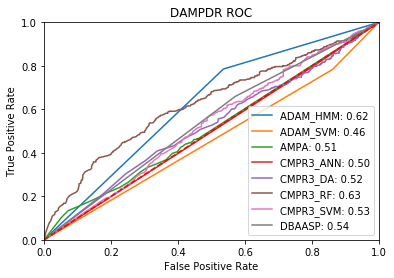

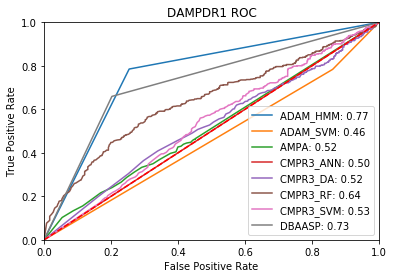

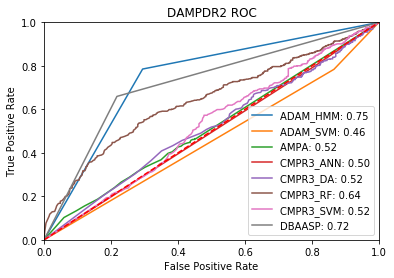

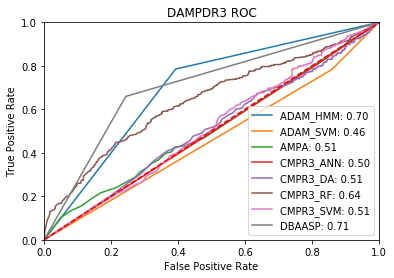

In [10]:
for r in REVERSE:
    plot_roc('DAMPD', 'D', r)

## Feature Dependence Analysis

### Length vs Prediction Probability

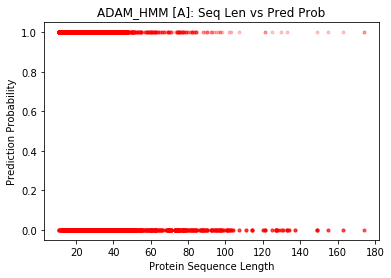

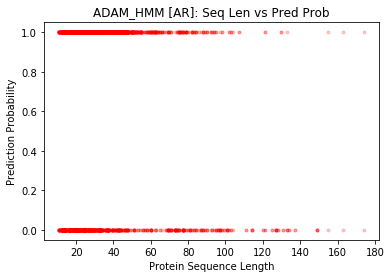

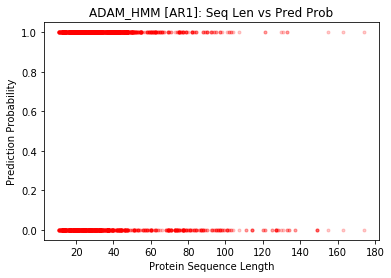

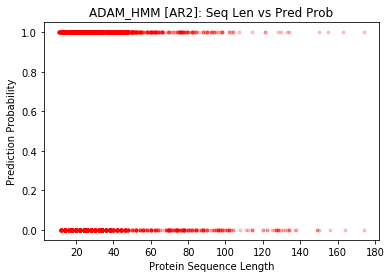

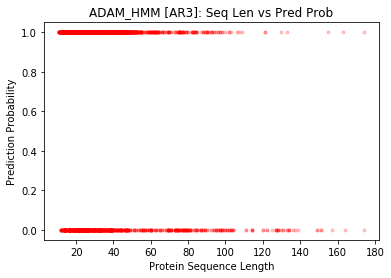

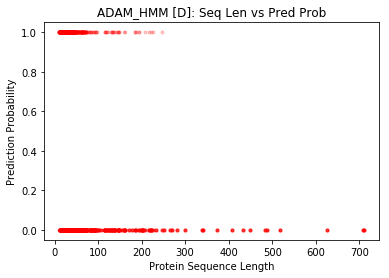

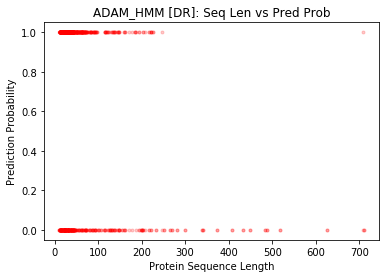

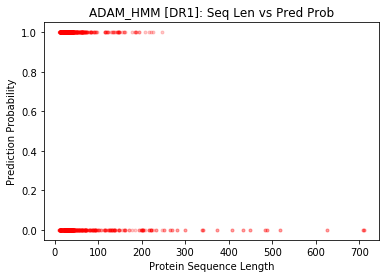

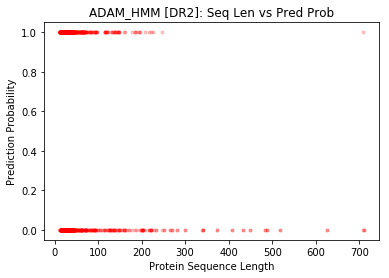

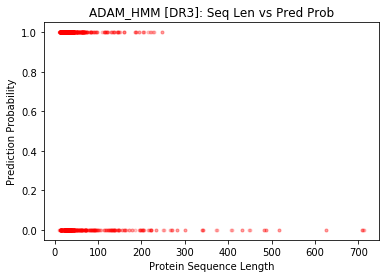

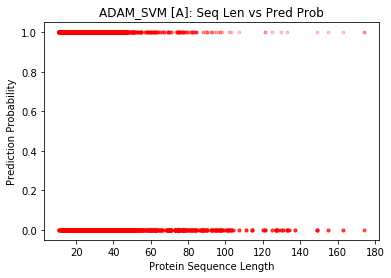

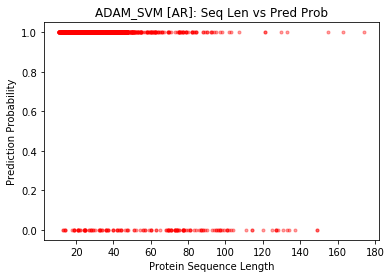

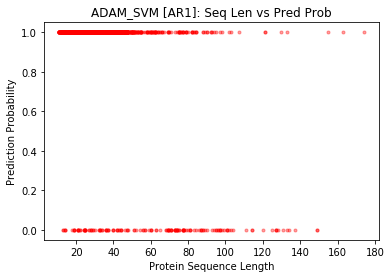

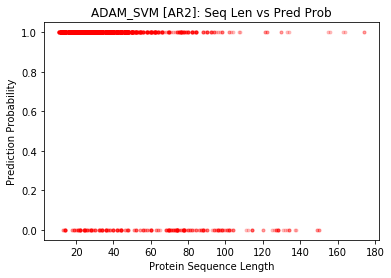

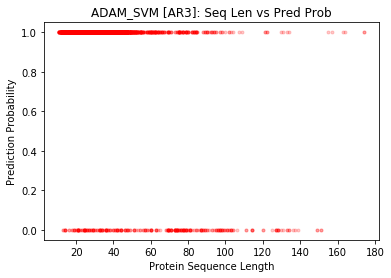

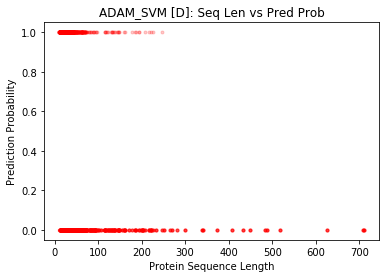

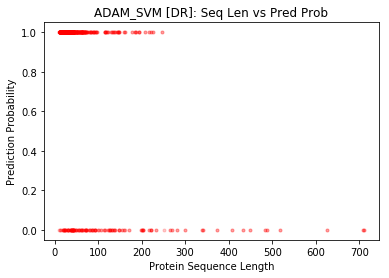

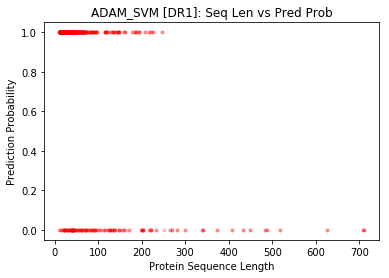

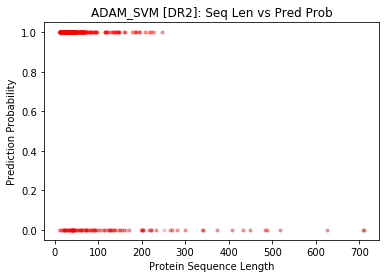

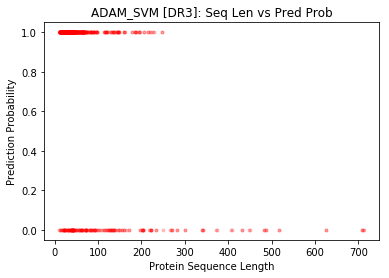

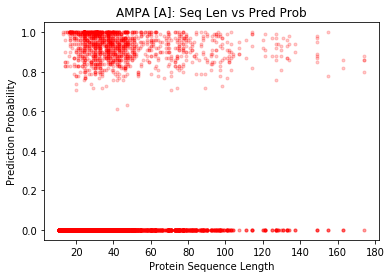

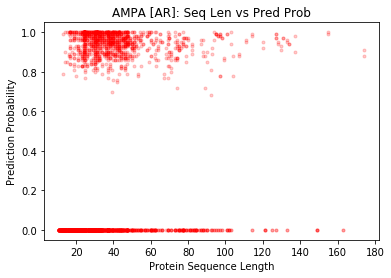

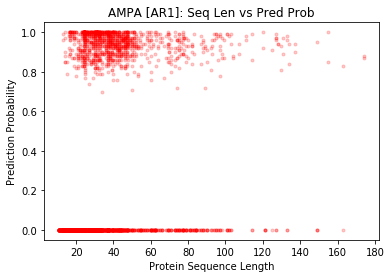

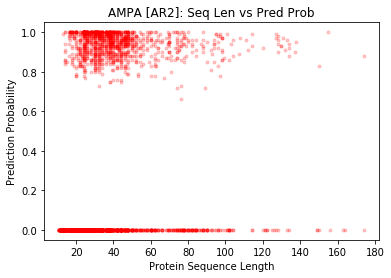

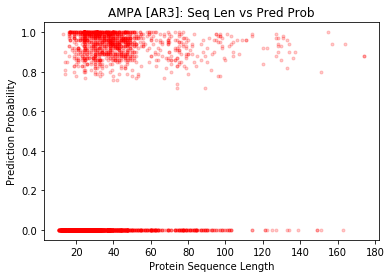

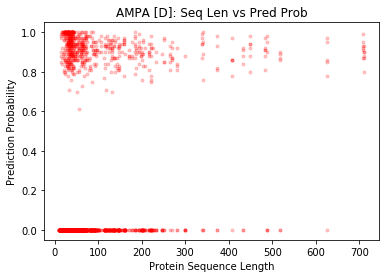

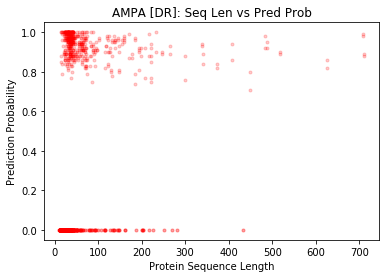

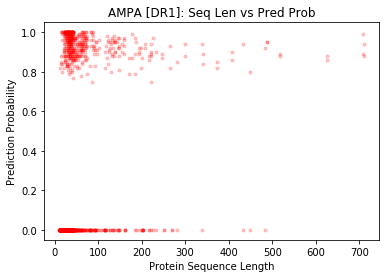

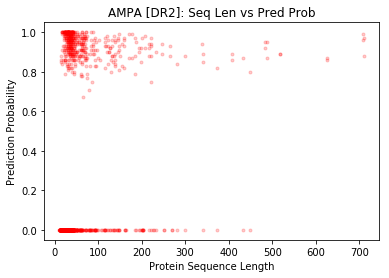

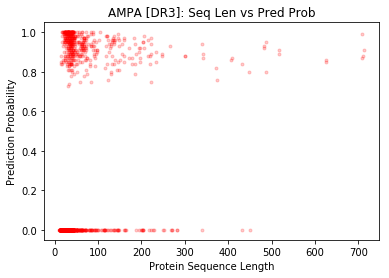

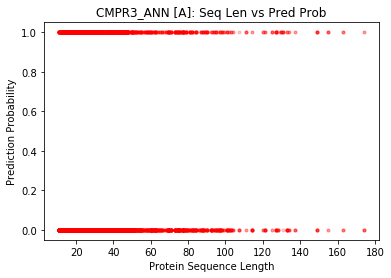

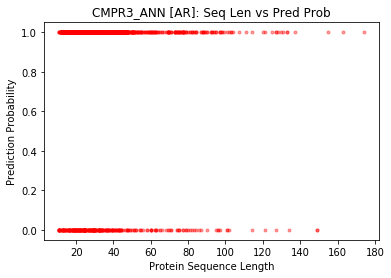

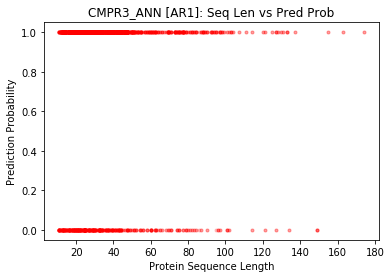

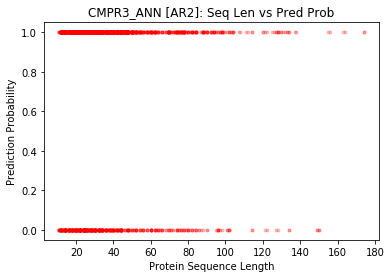

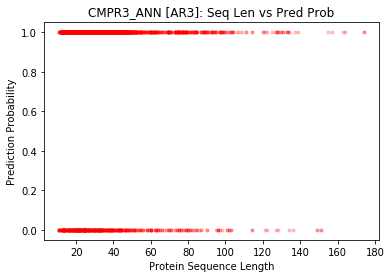

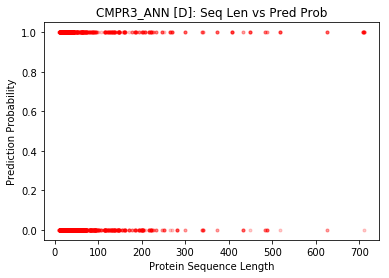

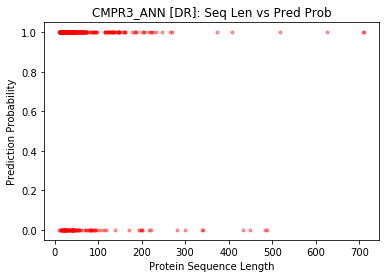

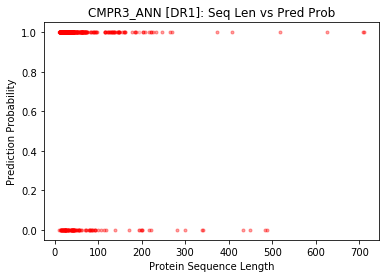

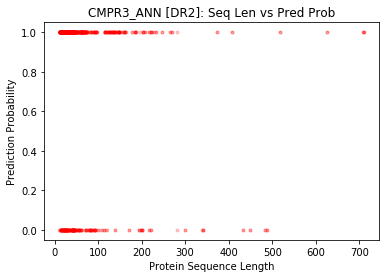

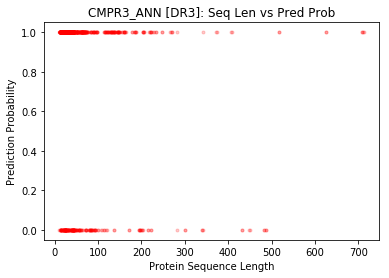

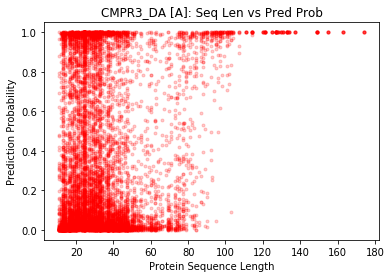

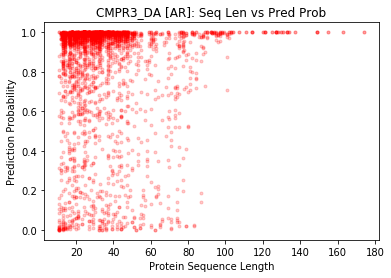

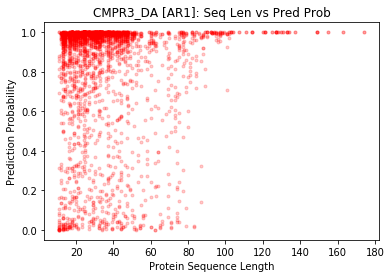

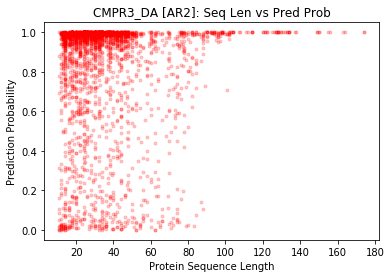

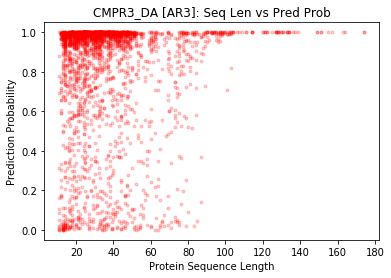

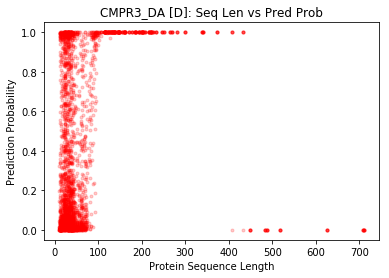

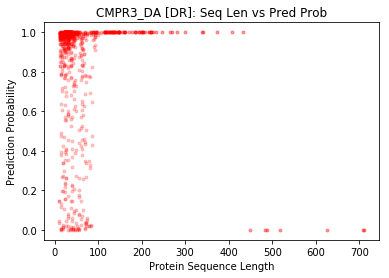

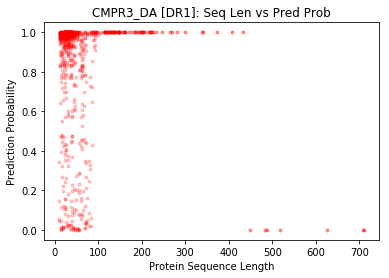

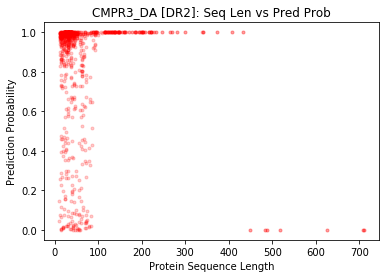

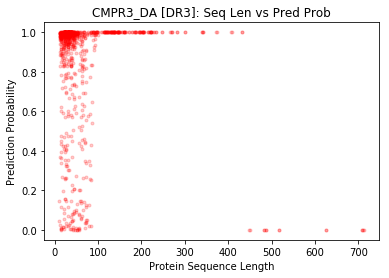

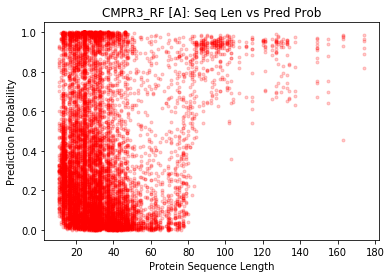

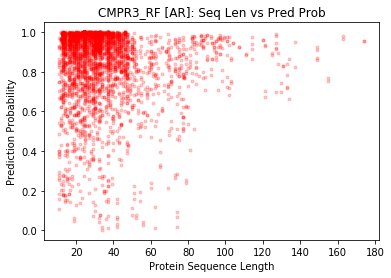

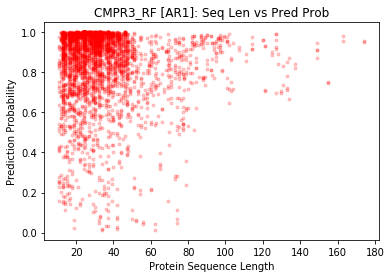

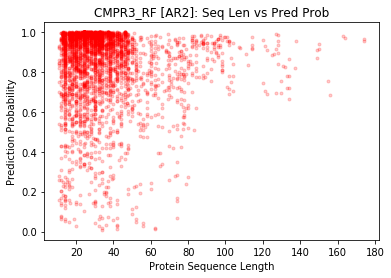

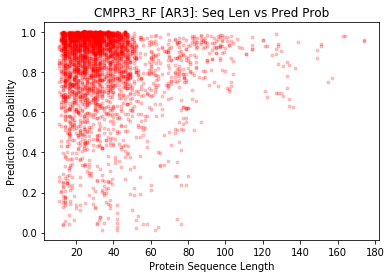

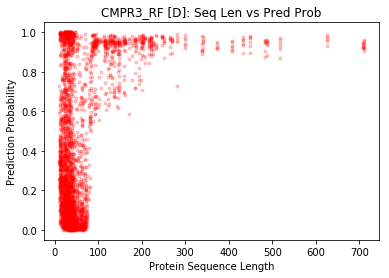

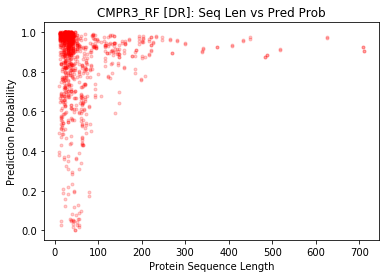

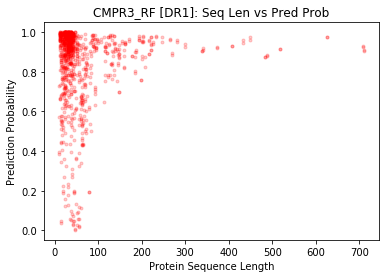

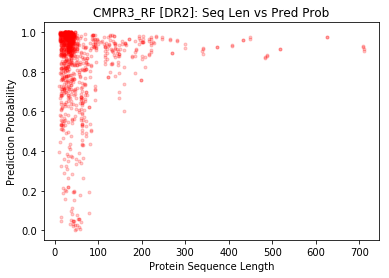

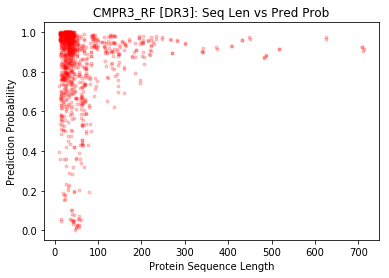

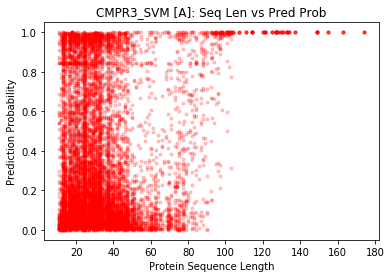

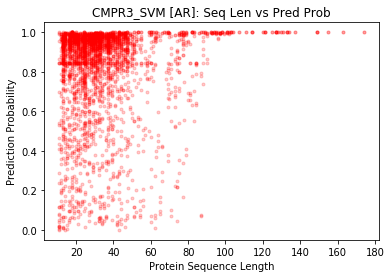

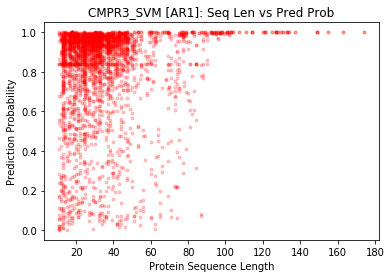

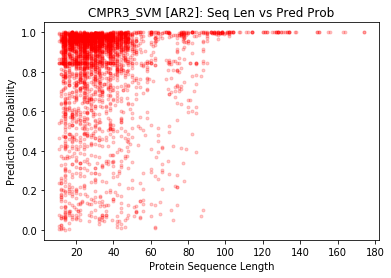

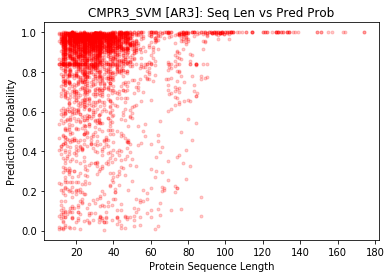

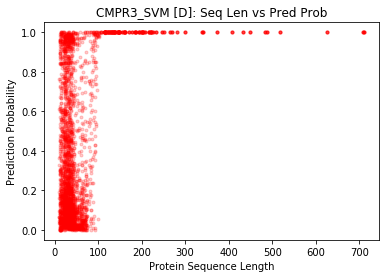

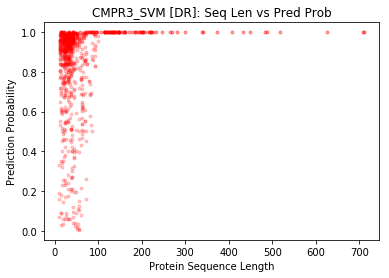

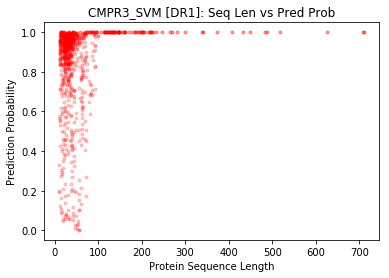

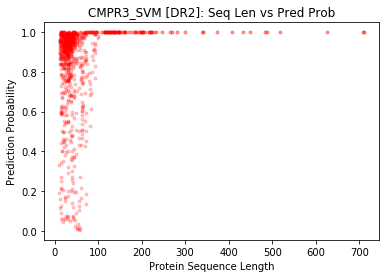

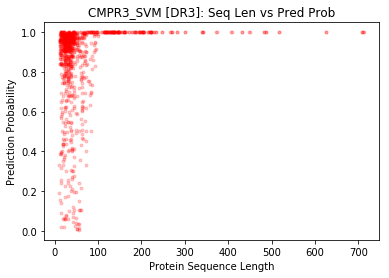

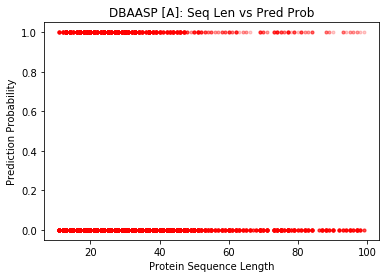

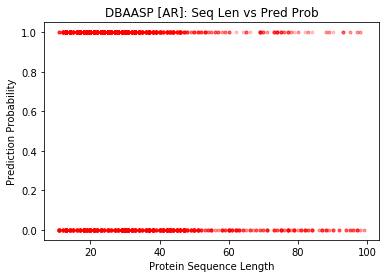

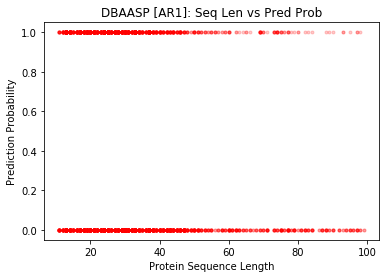

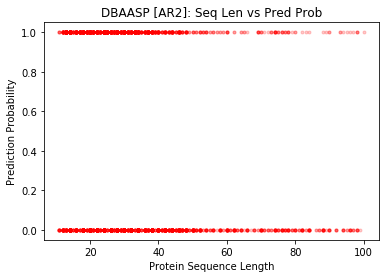

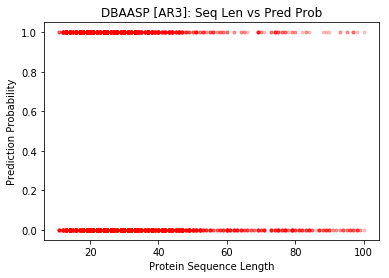

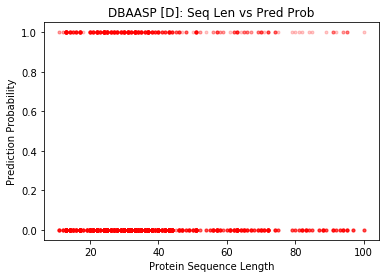

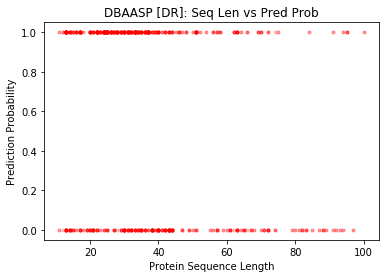

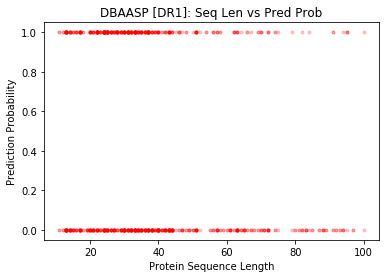

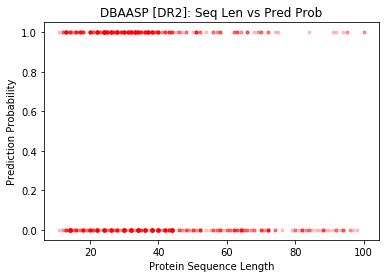

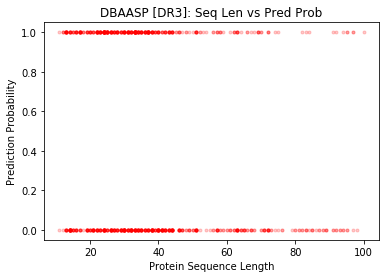

In [11]:
for s in SERVERS:
    for d in DATASET:
        for r in REVERSE:
            plt.title(s + ' ['+d+r+']' + ': Seq Len vs Pred Prob')
            plt.plot(data[s][d][r]['PepSeq'].apply(len), data[s][d][r]['PredScore'], 'r.', alpha=0.2)
            plt.xlabel('Protein Sequence Length')
            plt.ylabel('Prediction Probability')
            plt.show()

### Number of Unique Protein Count vs Prediction Probability

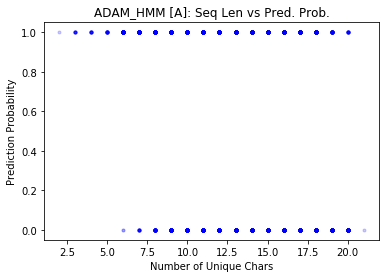

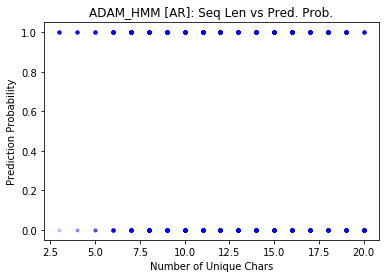

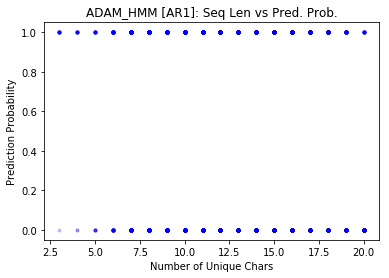

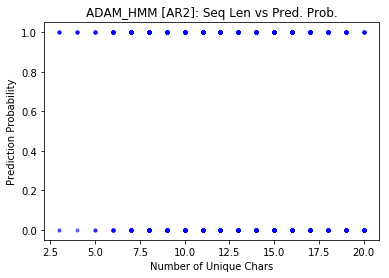

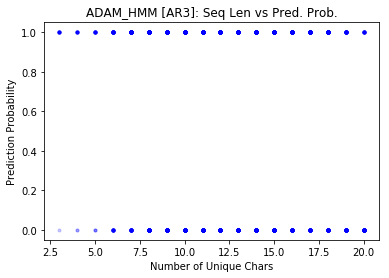

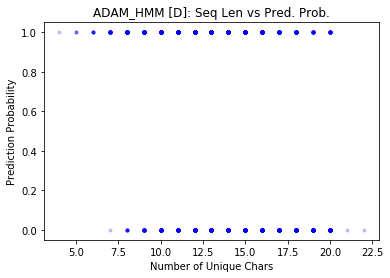

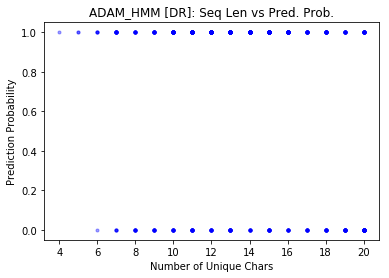

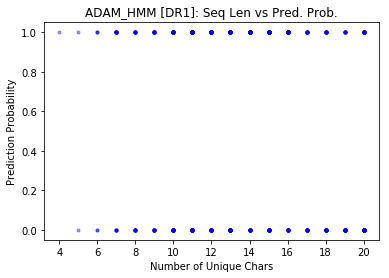

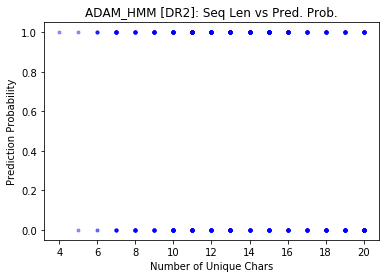

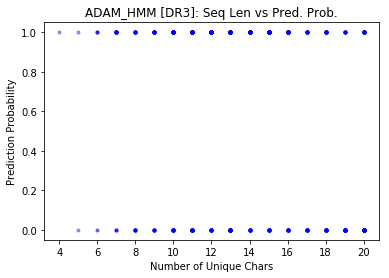

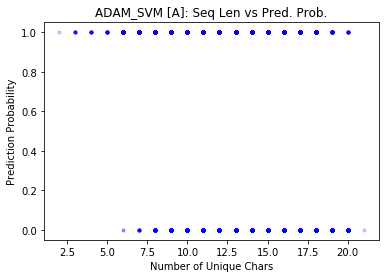

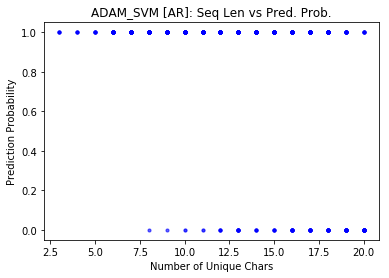

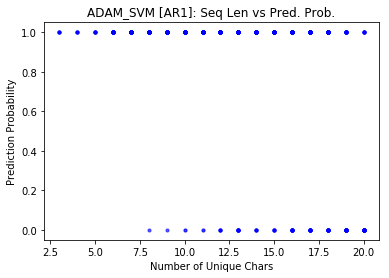

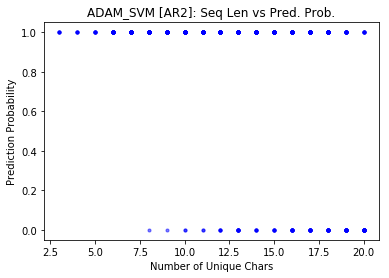

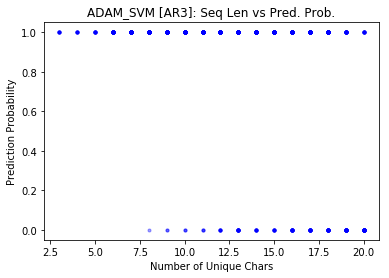

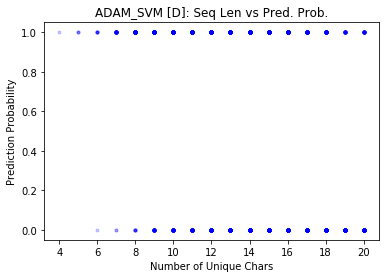

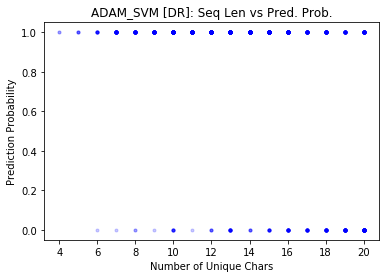

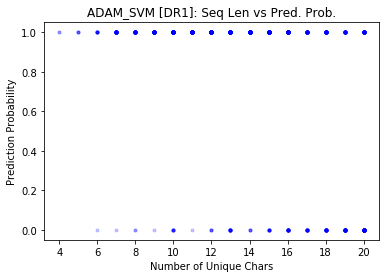

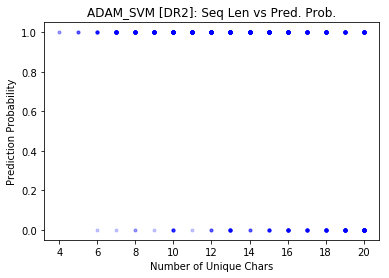

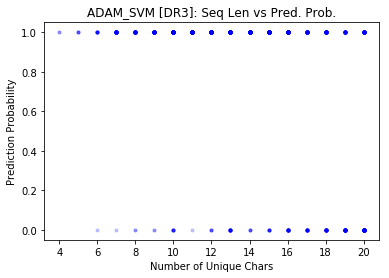

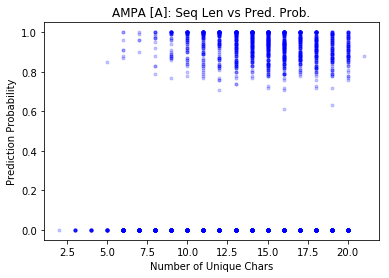

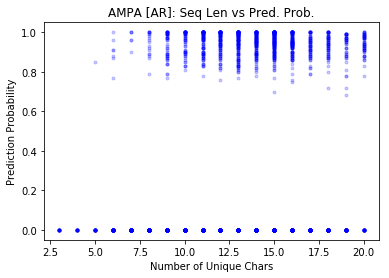

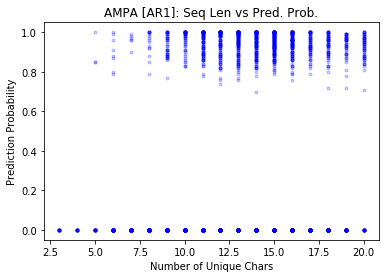

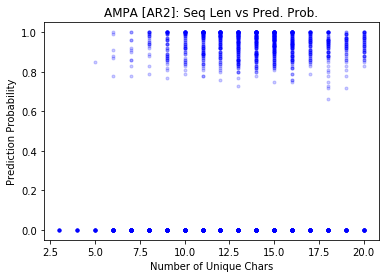

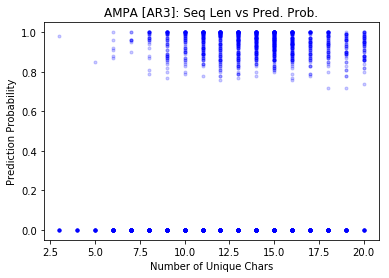

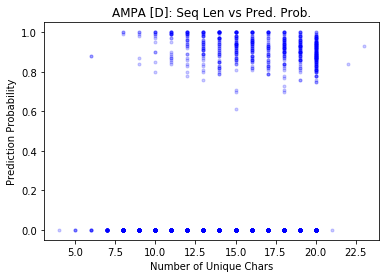

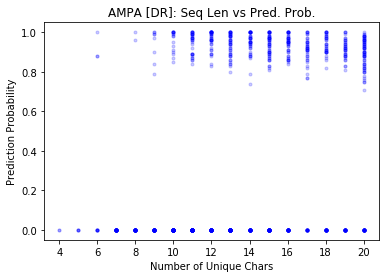

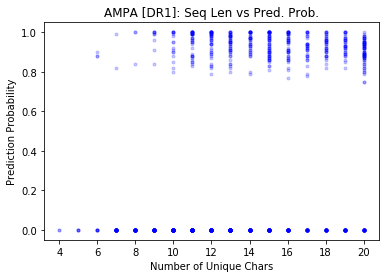

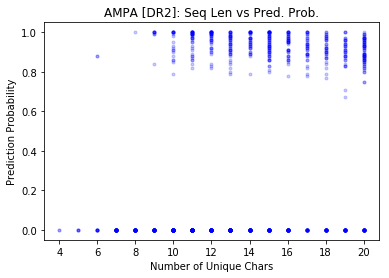

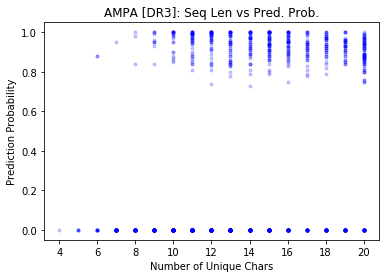

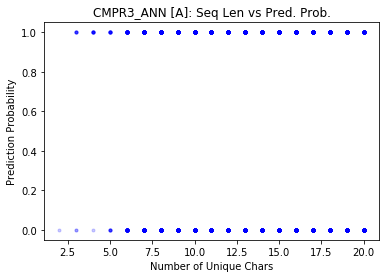

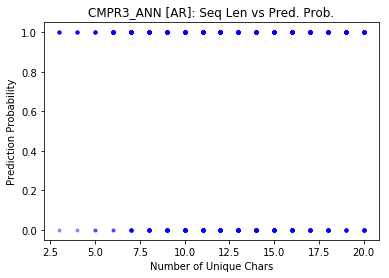

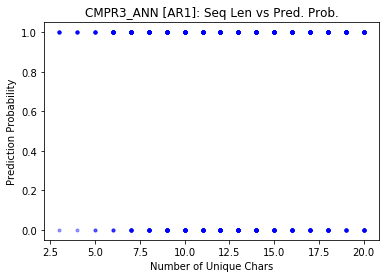

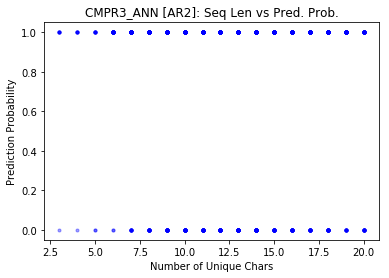

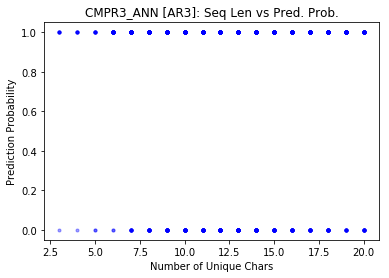

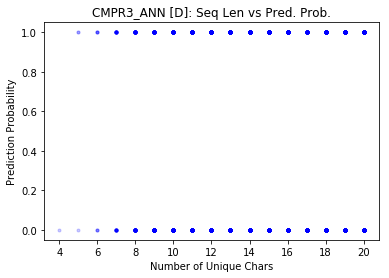

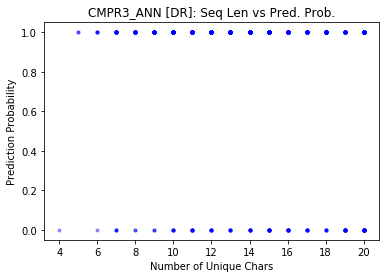

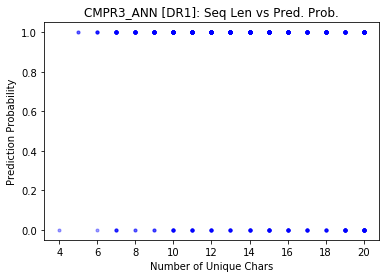

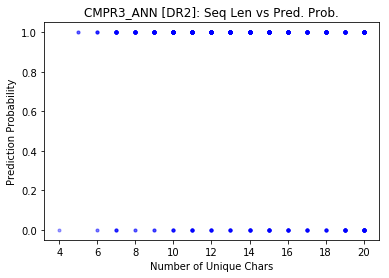

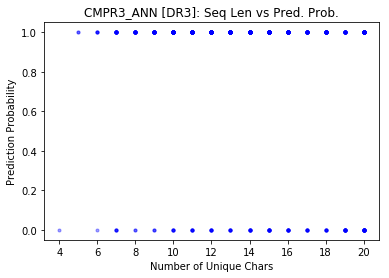

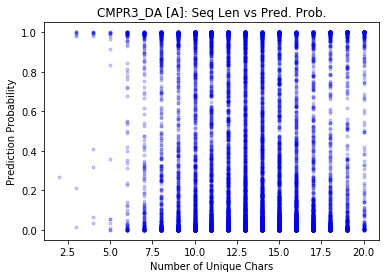

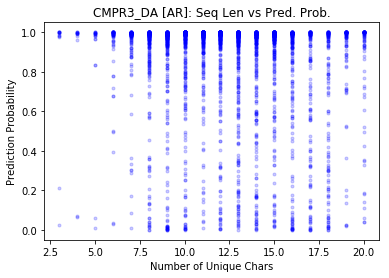

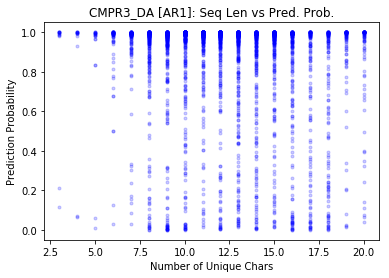

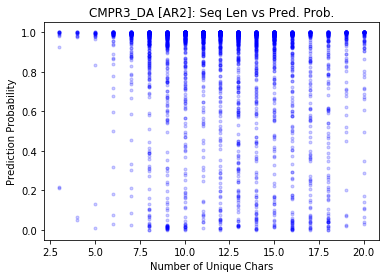

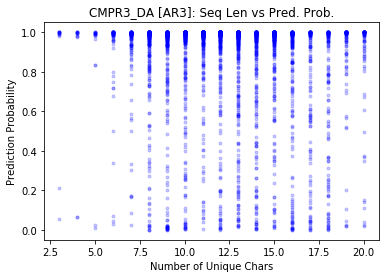

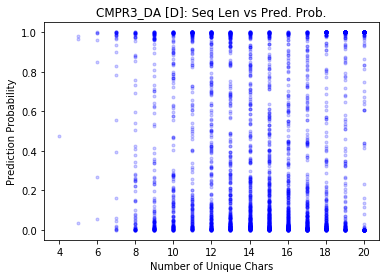

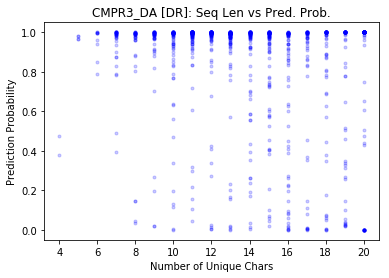

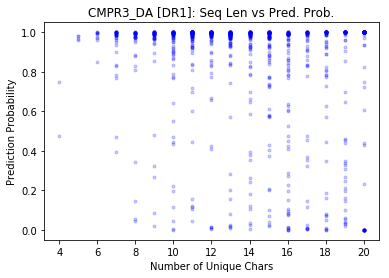

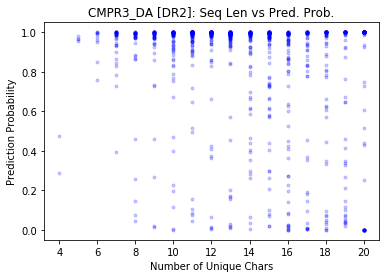

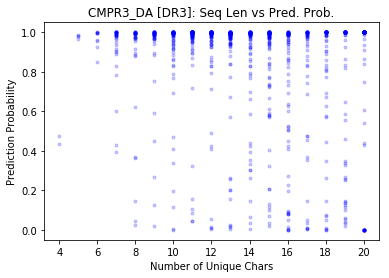

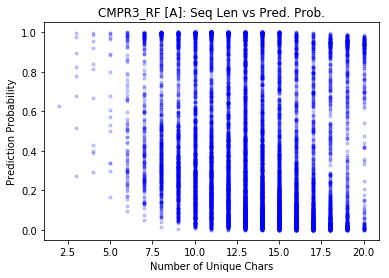

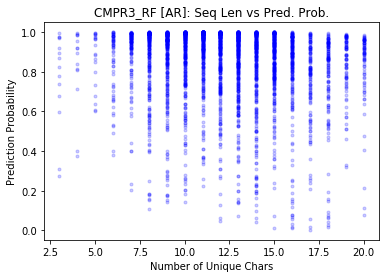

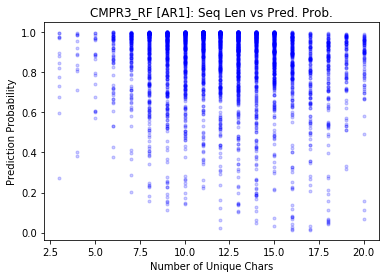

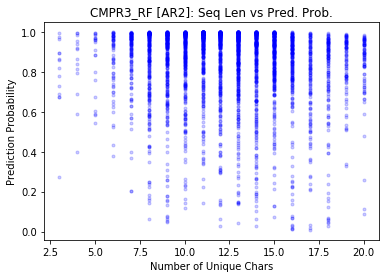

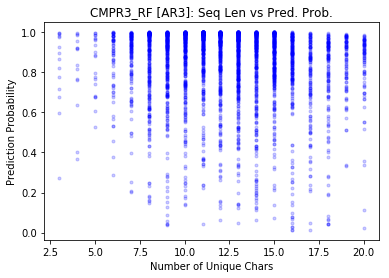

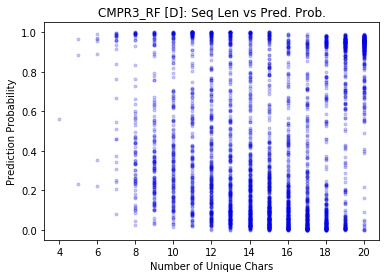

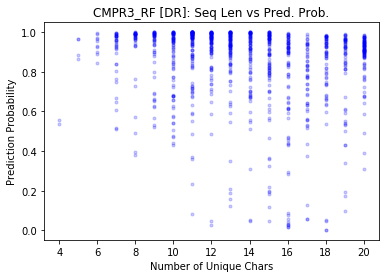

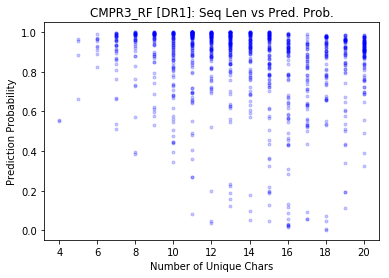

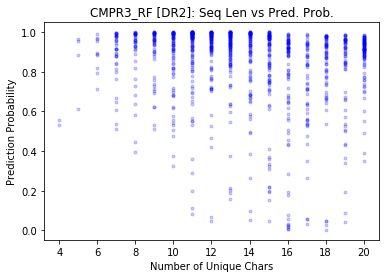

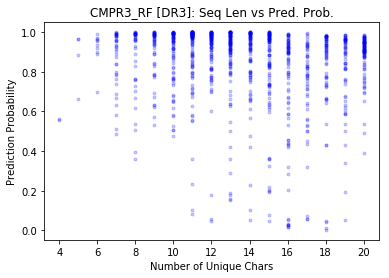

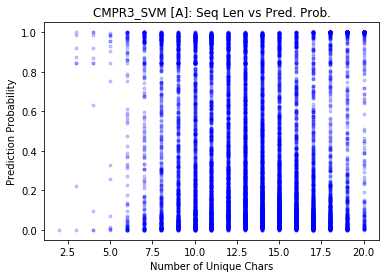

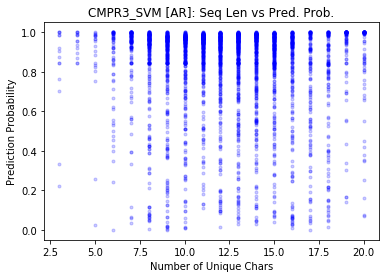

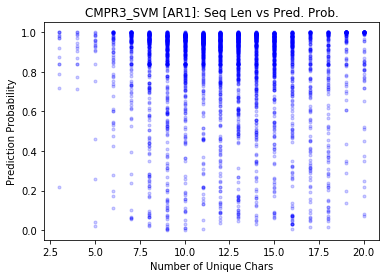

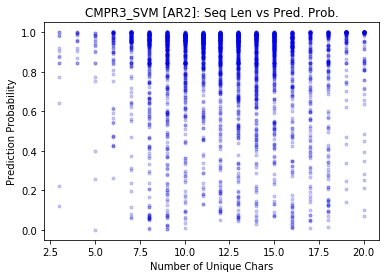

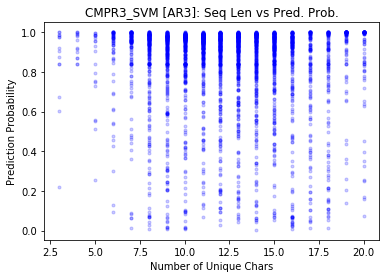

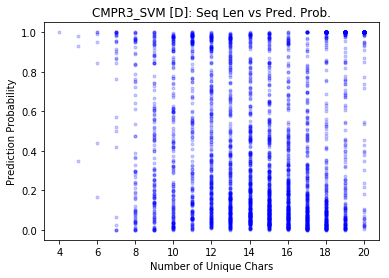

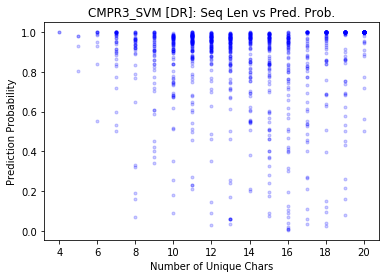

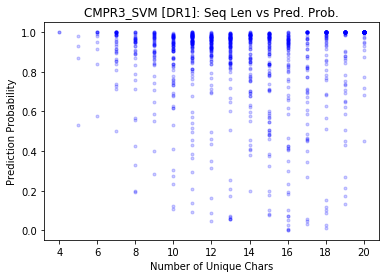

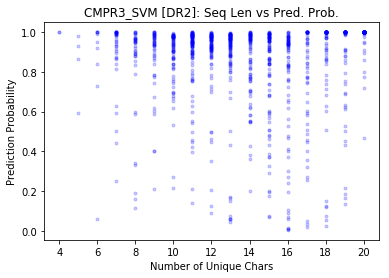

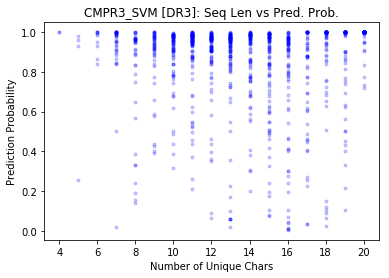

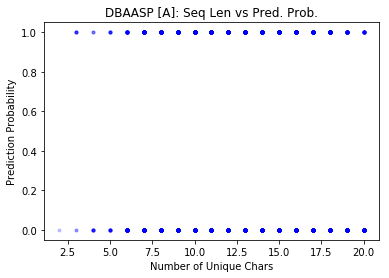

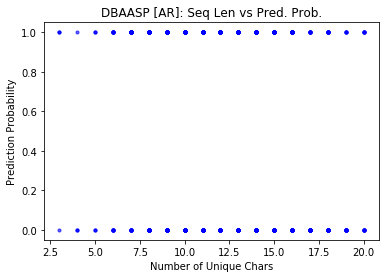

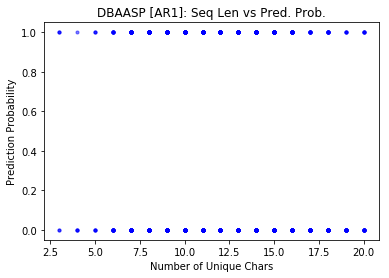

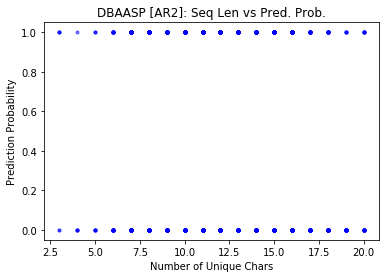

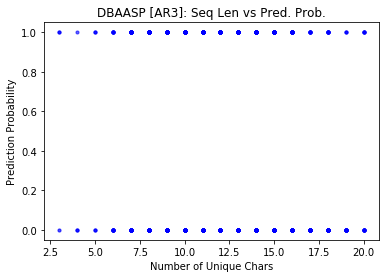

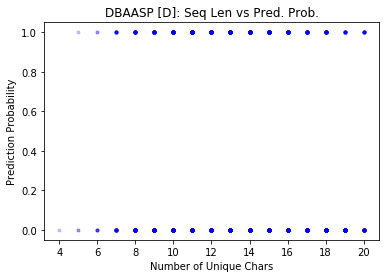

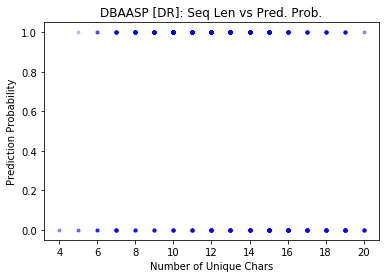

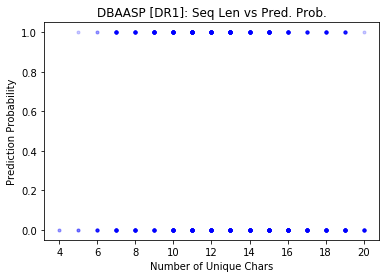

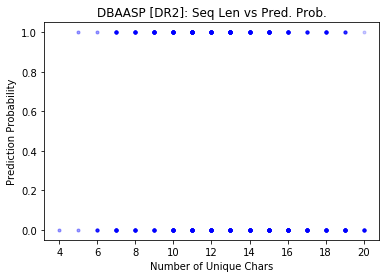

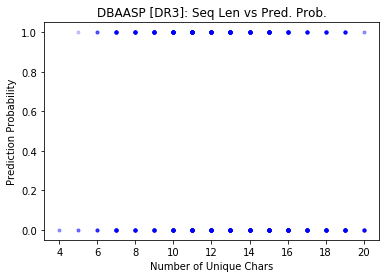

In [12]:
for s in SERVERS:
    for d in DATASET:
        for r in REVERSE:
            plt.title(s + ' ['+d+r+']' + ': Seq Len vs Pred. Prob.')
            plt.plot(data[s][d][r]['PepSeq'].apply(lambda x: len(set(x))), data[s][d][r]['PredScore'], 'b.', alpha=0.2)
            plt.xlabel('Number of Unique Chars')
            plt.ylabel('Prediction Probability')
            plt.show()